#Dataset
The data is contained in three files:

*   portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
*   profile.json - demographic data for each customer
*   transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**

*   id (string) - offer id
*   offer_type (string) - type of offer ie BOGO, discount, informational
*   difficulty (int) - minimum required spend to complete an offer
*   reward (int) - reward given for completing an offer
*   duration (int) - time for offer to be open, in days
*   channels (list of strings)

**profile.json**

*   age (int) - age of the customer
*   became_member_on (int) - date when customer created an app account
*   gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
*   id (str) - customer id
*   income (float) - customer's income

**transcript.json**

*   event (str) - record description (ie transaction, offer received, offer viewed, etc.)
*   person (str) - customer id
*   time (int) - time in hours since start of test. The data begins at time t=0
*   value - (dict of strings) - either an offer id or transaction amount depending on the record


In [6]:
import pandas as pd
import numpy as np
import json

from sklearn.cluster import KMeans
from modules.binomial import BinomialExperiment

import matplotlib.pyplot as plt
import matplotlib.ticker as tck


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
portfolio = pd.read_json('drive/MyDrive/Starbucks_Data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('drive/MyDrive/Starbucks_Data/profile.json', orient='records', lines=True)
transcript = pd.read_json('drive/MyDrive/Starbucks_Data/transcript.json', orient='records', lines=True)

# Data Wrangling

##Exploration & Cleaning

### Profile

In [8]:
print(profile.shape)
profile.head()

(17000, 5)


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [9]:
# closer look at age = 118 shows this to be a "dummy" value with no gender info and no income info.
profile.query('age == 118')

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


In [10]:
print("Age = 118 count: " + str(len(profile[profile.age == 118])))
print("Gender = None count: " + str(sum(profile['gender'].isna())))
print("Income = NA count: " + str(sum(profile['income'].isna())))

Age = 118 count: 2175
Gender = None count: 2175
Income = NA count: 2175


In [11]:
# convert dates to Datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

# fill gender NA's with unknown
profile['gender'] = profile['gender'].fillna('Unknown') 

# replace income na's with 0 -- will create buckets of income from 0-30k that will satisfy "unknowns"
profile['income'].fillna(0, inplace = True)
profile['income_bucket'] = pd.cut(profile['income'], bins = [0, 30000, 50000, 80000, 200000], labels = ["unknown", "under 50k", "50k-80k", "over 80k"], include_lowest=True)

profile['age_bucket'] = pd.cut(profile['age'], bins = [0,24,40,60,80,117,200], labels = ['24 and Under','25-40','41-60','61-80','81 and Over','Unknown'], include_lowest = False)


Text(0.5, 1.0, 'Became Member On')

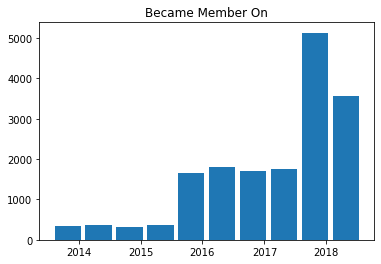

In [12]:
plt.hist(x=profile.became_member_on, rwidth=0.85)
plt.title('Became Member On')

became member is heavily scewed toward new users and does not contain enough variablity for segmentation. 

In [13]:
# drop income, age, became member on
profile = profile.drop(columns = ['income', 'age', 'became_member_on'])

In [14]:
profile.head()

,gender,id,income_bucket,age_bucket
0,Unknown,68be06ca386d4c31939f3a4f0e3dd783,unknown,Unknown
1,F,0610b486422d4921ae7d2bf64640c50b,over 80k,41-60
2,Unknown,38fe809add3b4fcf9315a9694bb96ff5,unknown,Unknown
3,F,78afa995795e4d85b5d9ceeca43f5fef,over 80k,61-80
4,Unknown,a03223e636434f42ac4c3df47e8bac43,unknown,Unknown


In [15]:
# Dummy encode the users frame to create our input array for clustering.
# Using dummy (not one-hot) to avoid correlation among dummy variables and improve clustering.
profile_dummies = pd.get_dummies(profile, columns = ['gender','income_bucket','age_bucket'], drop_first = False)

In [16]:
profile_dummies.head()

,id,gender_F,gender_M,gender_O,gender_Unknown,income_bucket_unknown,income_bucket_under 50k,income_bucket_50k-80k,income_bucket_over 80k,age_bucket_24 and Under,age_bucket_25-40,age_bucket_41-60,age_bucket_61-80,age_bucket_81 and Over,age_bucket_Unknown
0,68be06ca386d4c31939f3a4f0e3dd783,0,0,0,1,1,0,0,0,0,0,0,0,0,1
1,0610b486422d4921ae7d2bf64640c50b,1,0,0,0,0,0,0,1,0,0,1,0,0,0
2,38fe809add3b4fcf9315a9694bb96ff5,0,0,0,1,1,0,0,0,0,0,0,0,0,1
3,78afa995795e4d85b5d9ceeca43f5fef,1,0,0,0,0,0,0,1,0,0,0,1,0,0
4,a03223e636434f42ac4c3df47e8bac43,0,0,0,1,1,0,0,0,0,0,0,0,0,1


### Portfolio & Transcript

In [17]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [18]:
(portfolio.isnull()).sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [19]:
print(transcript.shape)
transcript.head()

(306534, 4)


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [20]:
(transcript.isnull()).sum()

person    0
event     0
value     0
time      0
dtype: int64

In [21]:
#closer look at 'value' for each event type
for e in transcript.event.unique():
    print(transcript.loc[transcript.event == e, ['event','value']].head(1).values)

[['offer received' {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}]]
[['offer viewed' {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}]]
[['transaction' {'amount': 0.8300000000000001}]]
[['offer completed'
  {'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2}]]


In [22]:
# Cleaning portfolio & transcript & combining with profile
# Filter df for important events, only (events with event ID attached, all we care about is response or non-response)
sig_events = ['offer received', 'offer viewed', 'offer completed']
filtered_df = transcript.loc[transcript['event'].isin(sig_events)].reset_index(drop = True).copy()

# Create offer_id variable from value NOTE: value is a series of dict. Offer ID key when event is viewed is "offer id." It's "offer_id" when event is completed.
filtered_df['offer_id'] = filtered_df['value'].apply(
  lambda x: x['offer_id'] if 'offer_id' in x.keys() else x['offer id']
  )
filtered_df.drop(columns = ['value'],
                     inplace = True)

# Dedup the dataframe for person, event and offer_id. Take min(time) for each.
deduped_df = filtered_df.groupby(['person','event','offer_id'], as_index = False)['time'].agg(np.min)

# Pivot out event with time as the values to see when each person received and completed each offer
pivoted_df = deduped_df.pivot(index = ['person','offer_id'], columns = ['event'], values = 'time').reset_index(drop = False)

# Filter pivoted_df so that we're only working with valid test cases for response rates
    # Must be a viewed time.
    # Completed time can't be less than viewed time (greater than and NaN both okay)
    # Days between view and receipt must <= the offer term in days
filtered_pivot = pivoted_df.loc[
  (~pivoted_df['offer viewed'].isnull()) &
  (~(pivoted_df['offer completed'] < pivoted_df['offer viewed']))
  ]
filtered_pivot = filtered_pivot.merge(
  portfolio[['id','duration','offer_type']],
  how = 'left',
  left_on = 'offer_id',
  right_on = 'id'
  ).drop(columns = 'id')
# Convert offer viewed and offer completed (hours) to days
filtered_pivot[['offer received','offer viewed','offer completed']] = filtered_pivot[['offer received','offer viewed', 'offer completed']] / 24

# Add a column for response, 1 if completion happened in offer window. Else 0.
filtered_pivot['offer_response'] = filtered_pivot.apply(
  lambda x: 1 if x['offer completed'] - x['offer received'] <= x['duration'] else 0, axis = 1
)

# filter the final product for only person that appears in users_clean
filtered_pivot = filtered_pivot.loc[filtered_pivot['person'].isin(profile['id'].unique())].reset_index(drop = True).copy()
filtered_pivot = filtered_pivot[['person','offer_id','offer_type','offer_response']]

In [23]:
filtered_pivot.head()

,person,offer_id,offer_type,offer_response
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,informational,0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,informational,0
2,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,bogo,0
3,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,1
4,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,1


# Cluster profile

In [24]:
profile_dummies.head()

,id,gender_F,gender_M,gender_O,gender_Unknown,income_bucket_unknown,income_bucket_under 50k,income_bucket_50k-80k,income_bucket_over 80k,age_bucket_24 and Under,age_bucket_25-40,age_bucket_41-60,age_bucket_61-80,age_bucket_81 and Over,age_bucket_Unknown
0,68be06ca386d4c31939f3a4f0e3dd783,0,0,0,1,1,0,0,0,0,0,0,0,0,1
1,0610b486422d4921ae7d2bf64640c50b,1,0,0,0,0,0,0,1,0,0,1,0,0,0
2,38fe809add3b4fcf9315a9694bb96ff5,0,0,0,1,1,0,0,0,0,0,0,0,0,1
3,78afa995795e4d85b5d9ceeca43f5fef,1,0,0,0,0,0,0,1,0,0,0,1,0,0
4,a03223e636434f42ac4c3df47e8bac43,0,0,0,1,1,0,0,0,0,0,0,0,0,1


In [25]:
profile_x = np.array(profile_dummies.drop(columns = 'id'))

In [26]:
# determine optimal centroids using within cluster sum of squares
css = []
for i in range(20):
    kmeans = KMeans(i+1)
    kmeans.fit(profile_x)
    css.append(kmeans.inertia_)

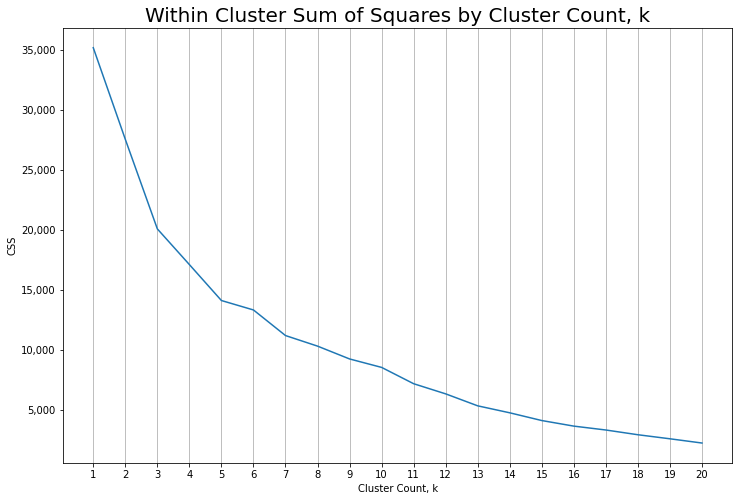

In [27]:
%matplotlib inline
# Plot wcss for each centroid count
fig, ax = plt.subplots(1,1,figsize = (12,8));
ax.plot([i+1 for i in range(20)], css);
ax.set_xticks([i+1 for i in range(20)]);
ax.grid(b = True, axis = 'x');
ax.yaxis.set_major_formatter(tck.StrMethodFormatter('{x:,.0f}'));
ax.set_ylabel('CSS', fontsize = 10);
ax.set_xlabel('Cluster Count, k', fontsize = 10);
ax.set_title('Within Cluster Sum of Squares by Cluster Count, k', fontsize = 20);

optimal clusters looks to be between 4 and 6. Let's split the difference and use 5

In [28]:
profile_kmeans = KMeans(5, random_state = 1)
label = profile_kmeans.fit_predict(profile_x)

In [29]:
# add cluster to profile
profile['cluster'] = label

In [30]:
profile.head()

,gender,id,income_bucket,age_bucket,cluster
0,Unknown,68be06ca386d4c31939f3a4f0e3dd783,unknown,Unknown,3
1,F,0610b486422d4921ae7d2bf64640c50b,over 80k,41-60,0
2,Unknown,38fe809add3b4fcf9315a9694bb96ff5,unknown,Unknown,3
3,F,78afa995795e4d85b5d9ceeca43f5fef,over 80k,61-80,0
4,Unknown,a03223e636434f42ac4c3df47e8bac43,unknown,Unknown,3


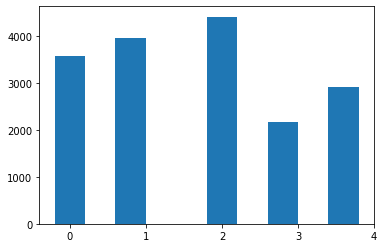

In [31]:
# Check to see if any segments are too small to be useful
fig_cluster, ax_cluster = plt.subplots(1,1)
ax_cluster.hist(profile.cluster, align = 'left');
ax_cluster.set_xticks(list(range(len(profile.cluster.unique()))));

In [32]:
def contrast_var_distributions(df, test_vars, segment_var = None):
    """
    Plots a series of histograms to contrast distributions of variables of interest.
    If a segment_var is provided, segments will be plotted in each figure to see how segments differ.
    """
    test_vars = test_vars
    n_test = len(test_vars)
    n_seg = len(df[segment_var].unique()) if segment_var else 1

    fig, ax = plt.subplots(n_test,n_seg,figsize = (8*n_seg,6*n_test))
    for i, col in enumerate(test_vars):
        if segment_var:
            # Get a color mapper object to allow me to color segments differently
            # Will also scale with added/removed segments
            # Color mapper object will have n_seg colors, each of which I can call by index with cmap(), later
            cmap = plt.cm.get_cmap('hsv', n_seg)
            for k, seg in enumerate(df[segment_var].unique()):
                ax[i,k].hist(
                    df[col][df[segment_var] == seg],
                    alpha = 0.5,
                    label = seg,
                    color = cmap(i),
                    edgecolor = 'black'
                )
                ax[i,k].set_title(col + ', Segment ' + str(seg), fontsize = 18)
                ax[i,k].legend()
                # Comma-format y axis ticks. Found here:
                # https://stackoverflow.com/questions/25973581/how-do-i-format-axis-number-format-to-thousands-with-a-comma-in-matplotlib
                ax[i,k].yaxis.set_major_formatter(tck.StrMethodFormatter('{x:,.0f}'))
        else:
            # Add 2 to cmap to avoid multiple charts of same color
            cmap = plt.cm.get_cmap('hsv', n_test + 2)
            ax[i].hist(
                df[col],
                color = cmap(i),
                edgecolor = 'black'
            )
            ax[i].set_title(col, fontsize = 18, pad = 20)
            ax[i].yaxis.set_major_formatter(tck.StrMethodFormatter('{x:,.0f}'))

            fig.tight_layout()

    return fig

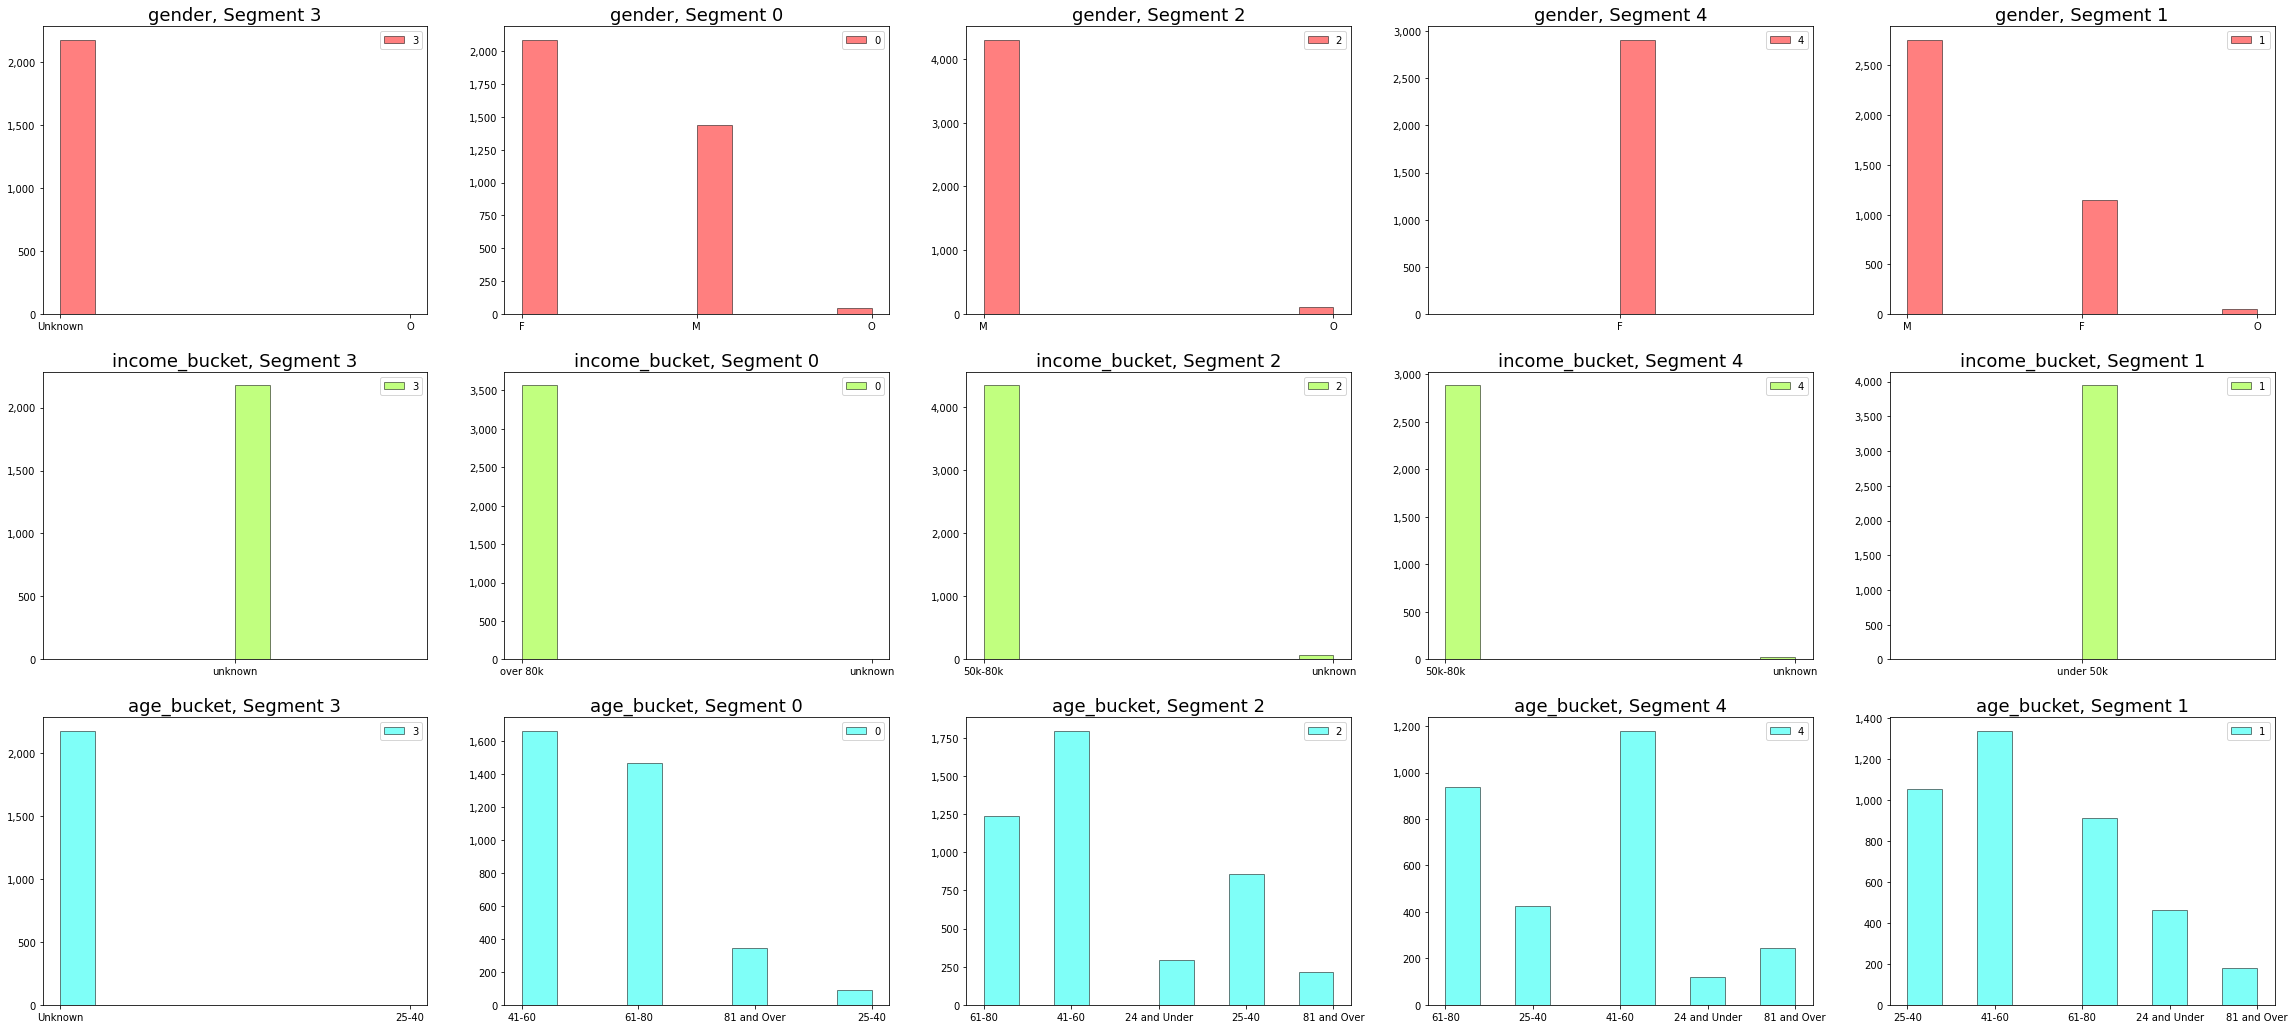

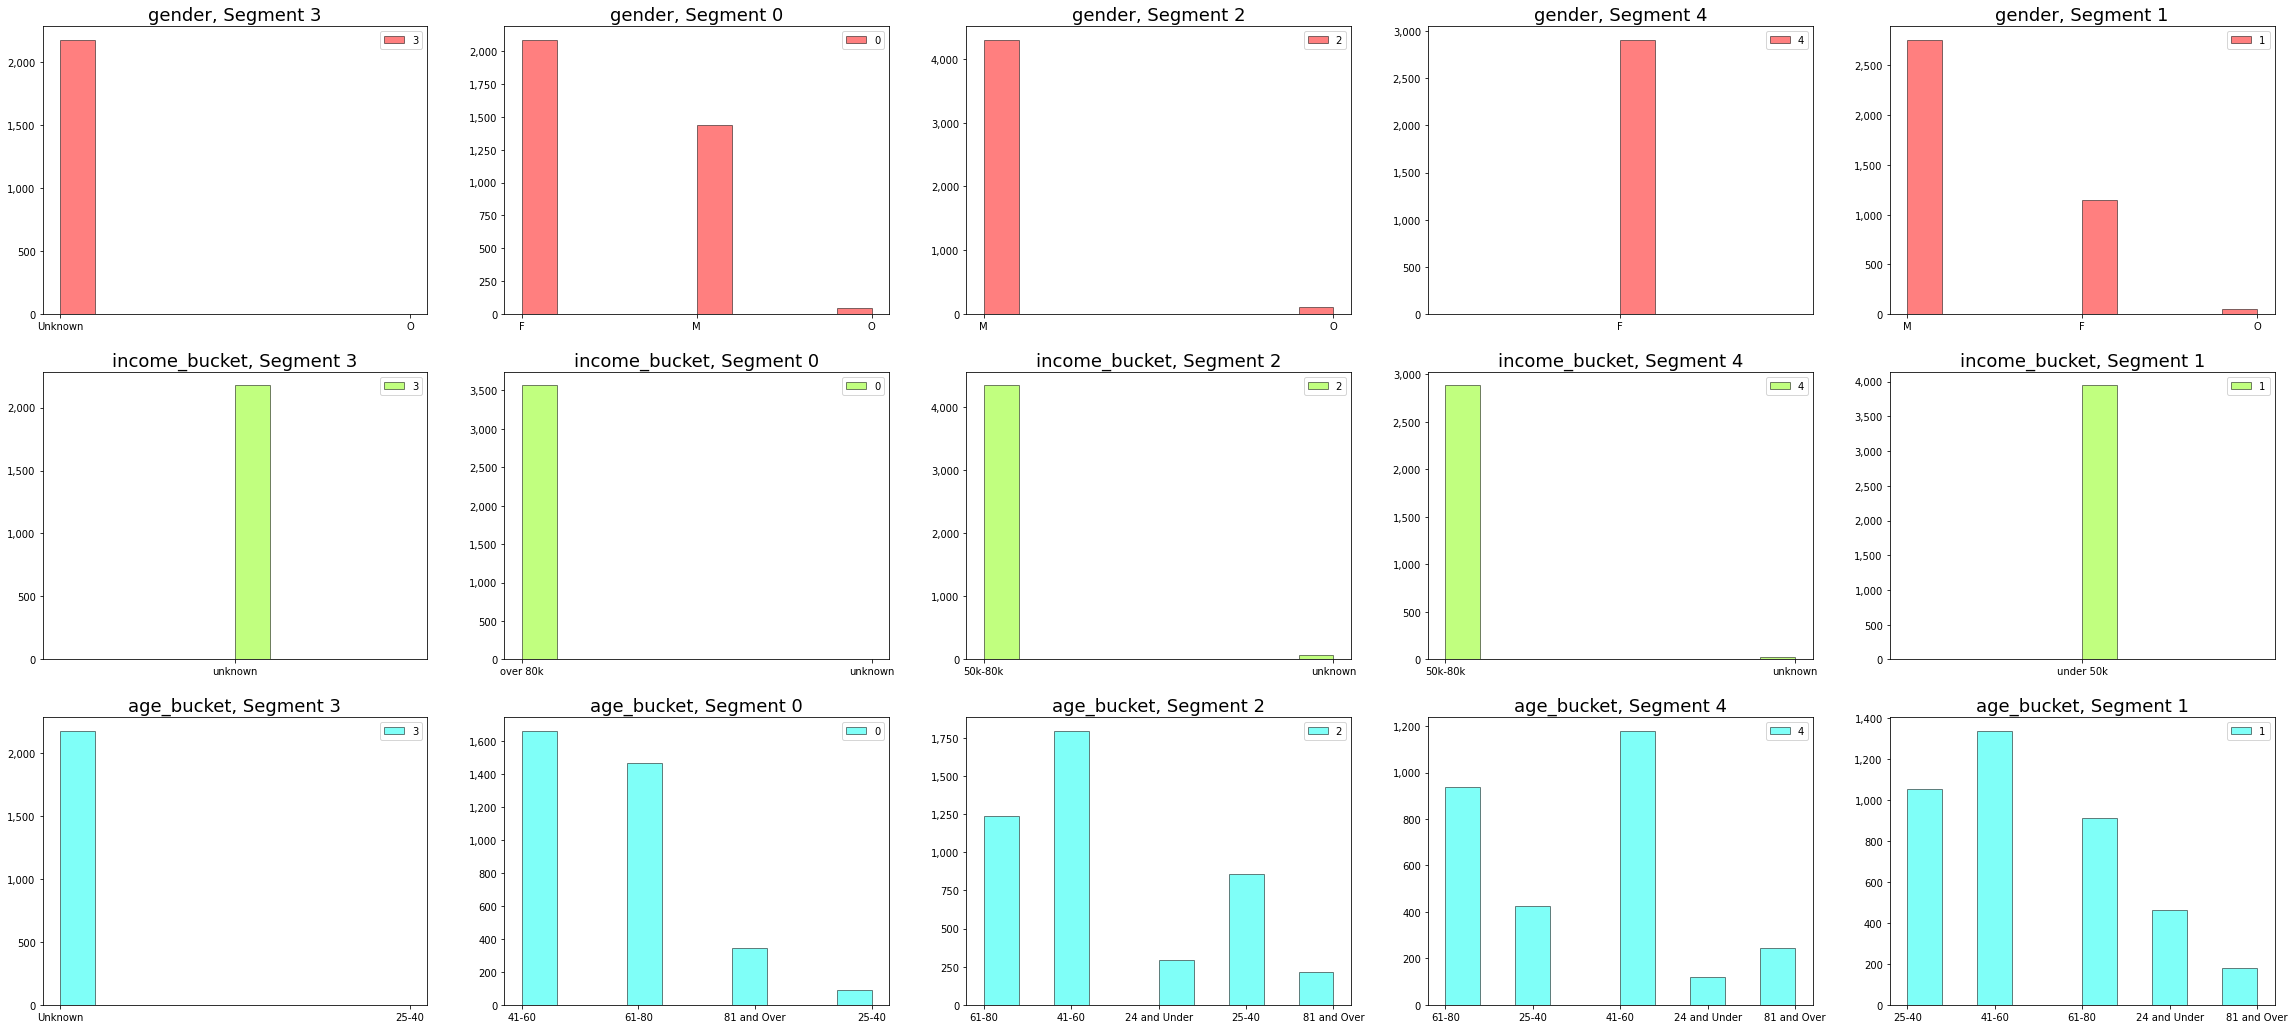

In [76]:
# Grid of histograms
contrast_var_distributions(profile, ['gender','income_bucket','age_bucket'], 'cluster')

Clusters:

In general:
*   Income was a prominent difference (1 unknown, 1 high, 1 low, 2 middle segments)
*   Gender was the secondary difference
*   Segments are mostly income/gender-based

Cluster-specific:
*   Cluster 0: High-Earners (more than 80k income). All ages.
*   Cluster 1: Low-Earners (under 50k income). All ages.
*   Cluster 2: Middle-Earners Male.
*   Cluster 3: The unknowns. Users who do not provide demo data.
*   Cluster 4: Middle-Earners Female.





## Response Rates by Cluster

In [33]:
# Merge cluster labels with filtered_pivot
responses = filtered_pivot.merge(profile[['id','cluster']], how = 'left', left_on = 'person', right_on = 'id').drop(columns = 'id')
responses.head()

,person,offer_id,offer_type,offer_response,cluster
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,informational,0,2
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,informational,0,2
2,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,bogo,0,3
3,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,1,2
4,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,1,2


In [34]:
# Check response rates for each discount type
response_rates = responses.groupby(
    ['cluster','offer_type'], 
    as_index = False
)['offer_response'].agg({'offer_response':'mean'}).round(2).pivot(
    index = 'cluster', 
    columns = 'offer_type', 
    values = 'offer_response')

response_rates

offer_type,bogo,discount,informational
cluster,,,
0,0.71,0.79,0.0
1,0.35,0.63,0.0
2,0.48,0.68,0.0
3,0.09,0.22,0.0
4,0.66,0.76,0.0


In [35]:
# no responses for informational, so drop it
response_tests = response_rates[['bogo','discount']]
response_tests

offer_type,bogo,discount
cluster,,
0,0.71,0.79
1,0.35,0.63
2,0.48,0.68
3,0.09,0.22
4,0.66,0.76


In [36]:
# Check each cluster's set of response rates for statistical significance
figs = dict()
for idx in response_tests.index:
    p_control = response_tests.loc[idx, 'bogo']
    p_treatment = response_tests.loc[idx, 'discount']
    
    n_control = len(responses[(responses.offer_type == 'bogo') & (responses.cluster == idx)])
    n_treatment = len(responses[(responses.offer_type == 'discount') & (responses.cluster == idx)])
    
    figs[idx] = BinomialExperiment(p_control = p_control, p_treatment = p_treatment, n_control = n_control, n_treatment = n_treatment).plot_confidence()

In [37]:
figs[0]

In [38]:
figs[1]

In [39]:
figs[2]

In [40]:
figs[3]

In [41]:
figs[4]

## Conclusion
Cluster 0, the High-Earners - This app user group responded over 70% to both bogos (71%) and discounts (79%). It is by far the most successful group regarding bogos. With this group, I would recommend changing very little, they tend to respond well to both bogos and discounts. 

Cluster 1, the Low-Earners - This app group responded to 35% of the bogo offers, but 63% of the discount offers. The inference here would suggest that low earners could also likely be single and bogo offers are generally less relevant as they don't often travel in pairs. My suggestion for this group would be to focus nearly entirely on discount offers rather than bogos. 

Cluster 2, The Male Middle-Earners - The male middle earners responded to 48% of the bogo offers and 68% to the discount offers. I would suggest focusing on more discount offers to entice more visits, but I would not stop bogo offers, they are still effective, but could be released to this user group at a slower pace than the discount offers. I would also see if overall instore data was available to look at the types of orders men make, so that the discounts can be tailored to them. 

Cluster 3, the Unknowns - This group was by far the least successful in responding as they responded to bogos at a 9% rate and discounts at a 22% rate. The response rate along with the fact they did not provide their demographics data suggests these users have very little involvement with Starbucks. My suggestion would be to entice them with a special discount to provide their demographics data first and foremost. Specialized campaigns to build more engagement with the app could also bring these fringe customers into the Starbucks fold. 

Cluster 4, the Female Middle-Earners - This group is the 2nd most successful group responding to 66% of the bogos and 76% of the discounts. I would not change much with this group; although knowing it is female, you could tailor the offers to orders more females make, if that data is available. 